<a href="https://colab.research.google.com/github/Heman9819/CloudCalci/blob/main/Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install -q cleverhans
!pip install -q plot_keras_history
!pip install -q keras-tuner

In [64]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.models import load_model


from sklearn.metrics import mean_squared_error
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
import numpy as np

import seaborn as sns
import pandas as pd

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
GOOGLE_COLAB = True

PROJECT_FOLDER = ''
# "/home/pro"

np.random.seed(10)

In [65]:
from cleverhans.tf2.attacks.spsa import spsa


In [66]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method


In [67]:
from cleverhans.tf2.attacks.madry_et_al import madry_et_al


In [68]:
!wget -q -O data.mat https://github.com/ocatak/6g-channel-estimation-dataset/blob/main/data.mat?raw=true
!wget -q -O util_defdistill.py https://github.com/ocatak/6g-channel-estimation-dataset/raw/main/util_defdistill.py
from util_defdistill import Distiller

In [69]:
print(PROJECT_FOLDER)

In [70]:
data = scipy.io.loadmat(PROJECT_FOLDER + 'data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

In [71]:
print(data['trainData'][0][0][0])

[-0.20781644  1.65345953  0.91287999 -1.28466812  0.16622813  0.3601839
  1.29061069  2.03752703 -0.79472239  0.49856683  0.74895407 -0.3705536
 -0.21330483 -0.01133832  1.05196991 -2.10783717  0.2852226   0.9190673
 -0.20752828  2.10163088  1.75404958 -1.21147169 -0.65210006  1.25321022
  0.91383124  0.94116564  1.14038099  0.42043599 -0.25420566  0.74937879
 -0.03686881  1.15630629  0.65009699  0.08999567  0.28439177  1.4834833
 -0.4734552   0.58922029  0.23494821  1.38463347  1.06860702 -0.28943787
 -1.1520814  -0.36469349  1.81869069  2.14104562  0.95821409 -0.11687384
  0.82013568 -0.85557367  1.26962069  1.8984319   0.84208733 -1.03795215
  0.48932296  1.90297673  1.90761534  0.27297307 -0.10423559 -0.75535064
 -1.58318216  1.27070892  2.33322916  0.43721734 -1.13170037  0.16093774
 -0.7501571   1.19243094  1.54458632  1.10504284  0.85972419  1.05292564
  0.47602844  1.30516019  1.78082186  1.57526952 -0.20832226  0.66227507
  1.1596755   1.83704245  2.06284308 -0.93062698 -1.058

In [72]:
print(valData.shape[0])

32


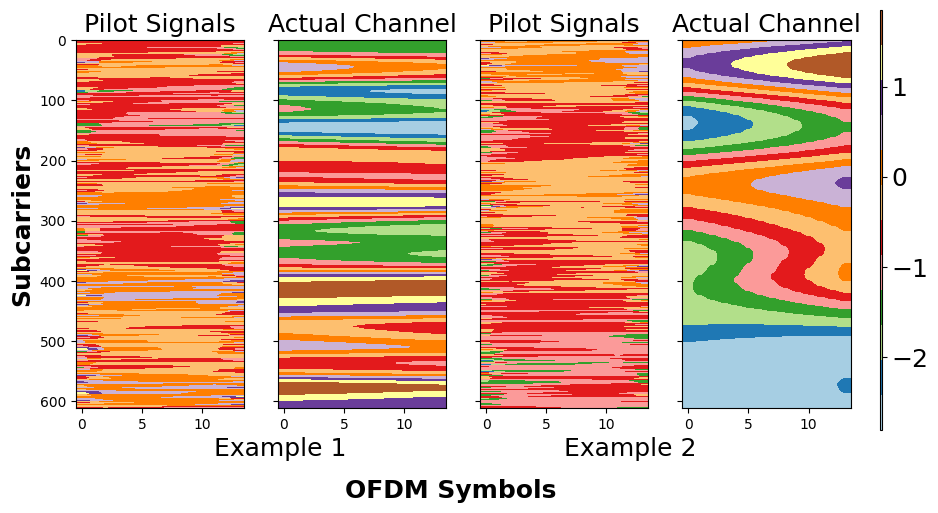

In [73]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

plt.show()

In [74]:
print(rand_idx[0])

9


In [75]:
def get_model(mult_factor = 1.0, model_name=''):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(layers.Conv2D(int(48*mult_factor), (9, 9), padding='same', activation='selu', input_shape=(612, 14, 1)))
    model.add(layers.Conv2D(int(16*mult_factor), (5, 5), padding='same', activation='softplus'))
    model.add(layers.Conv2D(1, (5, 5),  padding='same', activation='selu'))

    return model

In [76]:
STUDENT_MODEL_MULTIPLICATION = 0.5
TEACHER_MODEL_MULTIPLICATION = 1.0

model = get_model(STUDENT_MODEL_MULTIPLICATION, model_name = 'Student')

es_teacher = EarlyStopping(monitor='val_loss',
                          patience=50,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_model = model.fit(trainData, trainLabels,
              epochs=1,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

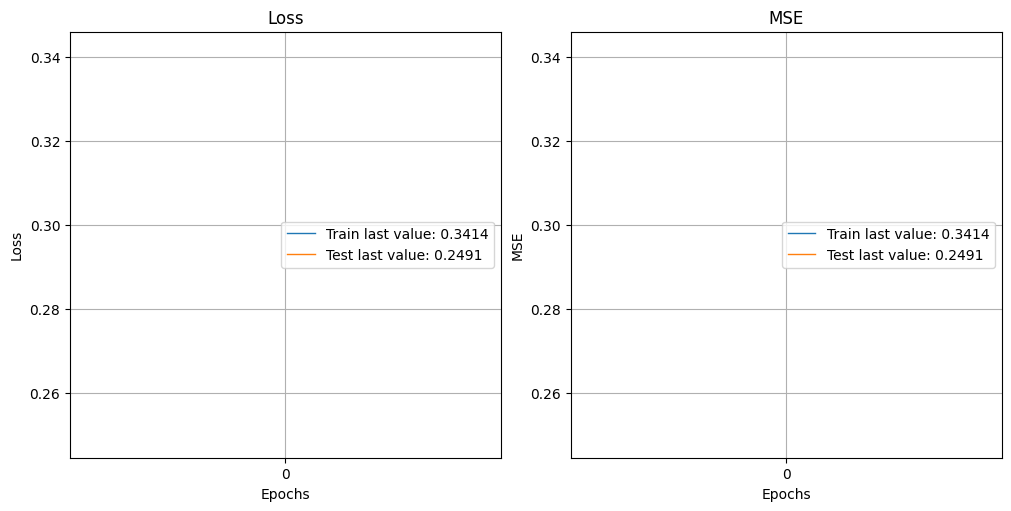

In [77]:
plot_history(hist_model.history)
plt.show()

1/1 [==============================] - 0s 198ms/step


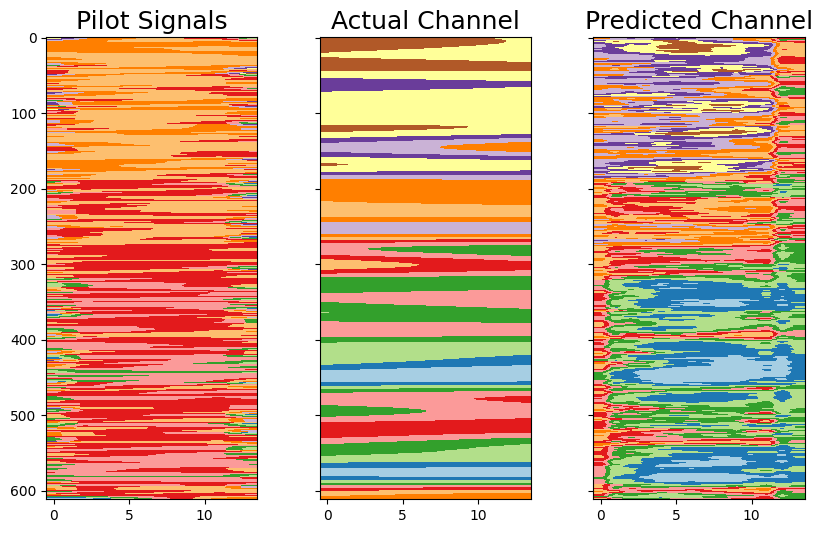

In [78]:




rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [79]:
student_model = get_model(STUDENT_MODEL_MULTIPLICATION, model_name = 'Student')
teacher_model = get_model(TEACHER_MODEL_MULTIPLICATION, model_name = 'Teacher')

#print('*'*70)
#student_model.summary()
#print('*'*70)
#teacher_model.summary()
#print('*'*70)

In [80]:
es_teacher = EarlyStopping(monitor='val_loss',
                          patience=200,
                          verbose=1,
                          restore_best_weights=True,
                          mode='min')

teacher_model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
# Train and evaluate teacher on data.
hist_teacher = teacher_model.fit(trainData, trainLabels,
              epochs=1,
              verbose=0,batch_size=128,
              callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

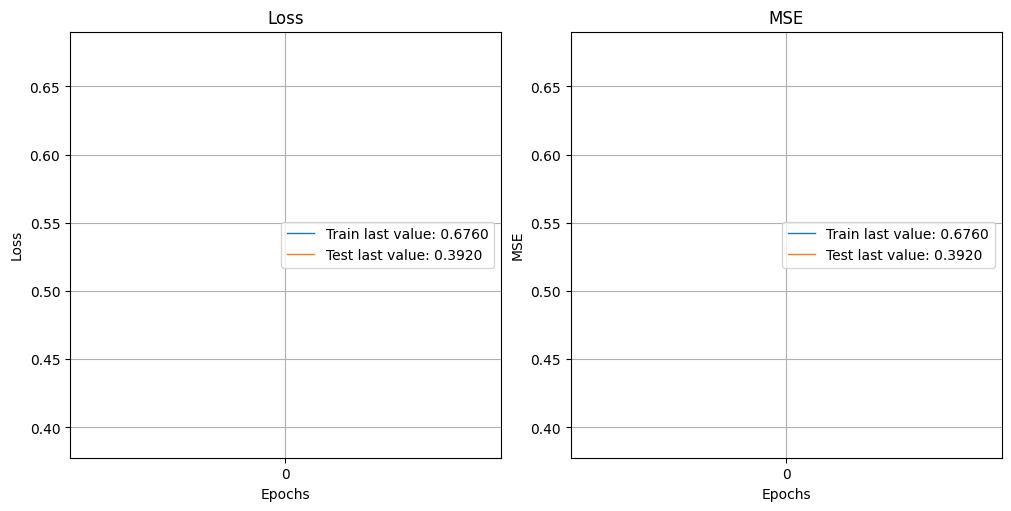

In [81]:
plot_history(hist_teacher.history)
plt.show()

1/1 [==============================] - 0s 82ms/step


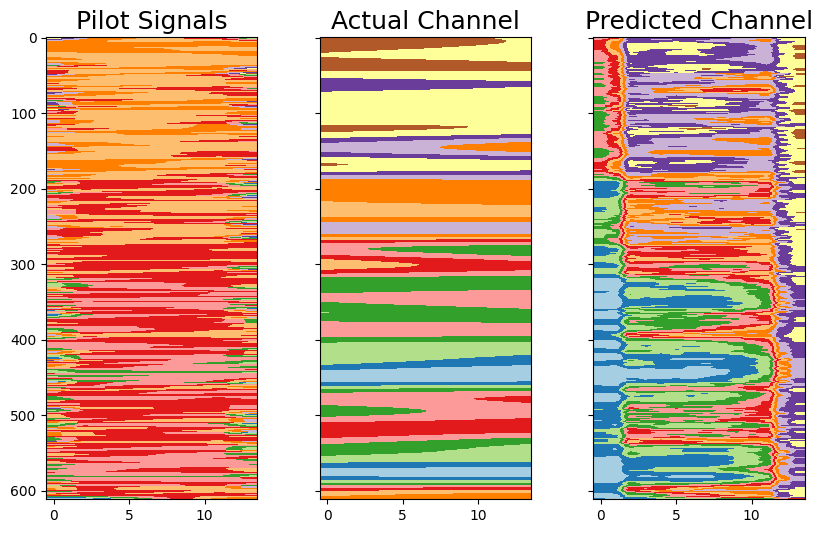

In [82]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = teacher_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [83]:
import keras
distiller = Distiller(student=student_model, teacher=teacher_model)
loss_fn = keras.losses.MeanSquaredError()

distiller.compile(optimizer='adam',
                            metrics=['mse'],
                            student_loss_fn=loss_fn,
                            distillation_loss_fn=keras.losses.KLDivergence(),
                            alpha=0.1,
                            temperature=20)

es = EarlyStopping(monitor='val_student_loss',
                   patience=150,
                   #min_delta=0.000001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

hist_distill = distiller.fit(trainData, trainLabels,
                              epochs=1,
                              verbose=0,
                              callbacks=[es,TqdmCallback(verbose=1, desc='DL training')],
                              validation_data=(valData, valLabels))

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

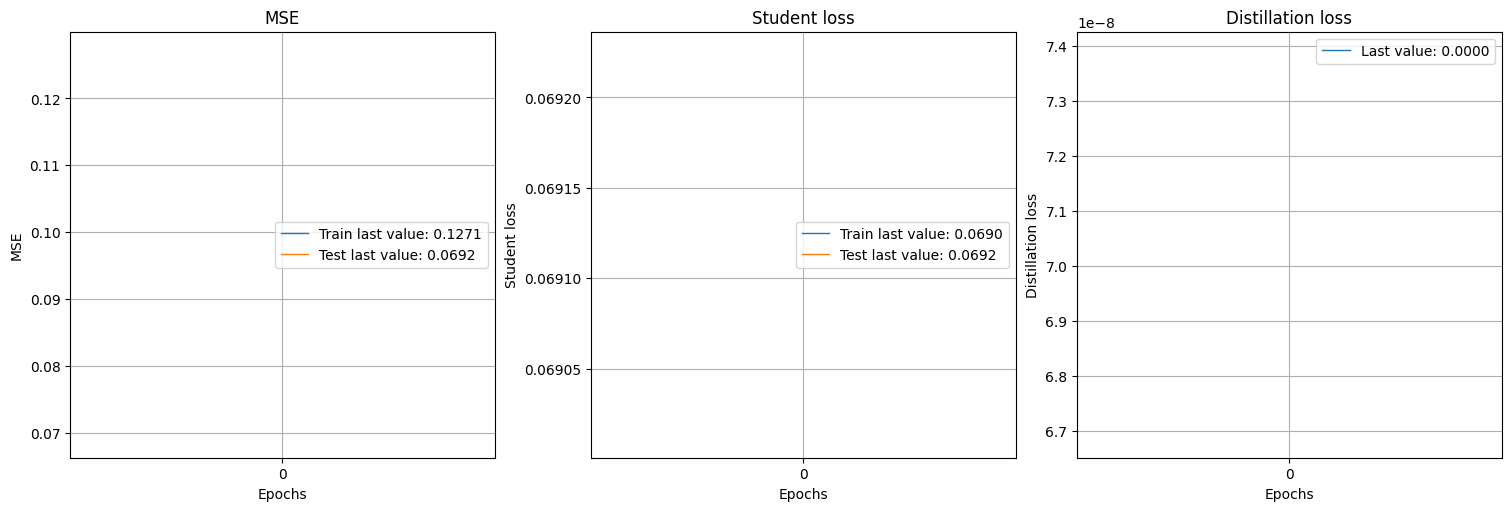

In [84]:
plot_history(hist_distill.history)
plt.show()

1/1 [==============================] - 0s 73ms/step


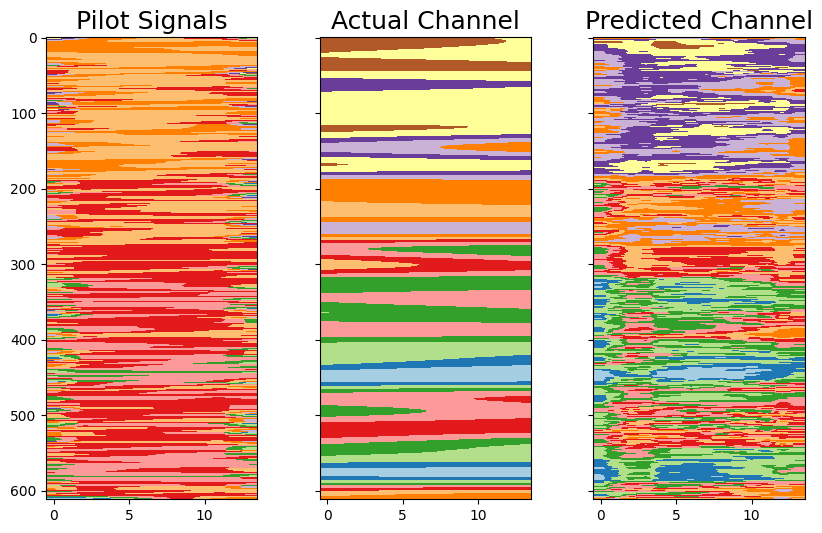

In [85]:
rand_idx = 4

test_input1 = valData[rand_idx:rand_idx+1,:]
real_output1 = valLabels[rand_idx:rand_idx+1,:]

pred = student_model.predict([test_input1,])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

ax[2].imshow(pred.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Predicted Channel',fontsize=font_size)

plt.show()

In [86]:
!git clone https://github.com/tensorflow/cleverhans

fatal: destination path 'cleverhans' already exists and is not an empty directory.


In [87]:
!git clone foolbox

fatal: repository 'foolbox' does not exist


In [88]:
# pip install cleverhans

In [89]:
# from cleverhans import utils_tf as utils
# from cleverhans.attacks import DeepFool

In [90]:
from keras.layers import Dense, Flatten
student_copy = tf.keras.models.clone_model(distiller.student)
for layer in student_copy.layers:
    	layer.trainable = False

student_copy.add(Flatten())
student_copy.add(Dense(2, activation='softmax'))
student_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
import tensorflow as tf
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method


def madry_et_al(model, x, eps=8/255, eps_iter=2/255, nb_iter=10, norm='l_inf',
                clip_min=None, clip_max=None):

  pgd_attack = ProjectedGradientDescent(model,
                                        sess=tf.get_default_session())

  x_adv = pgd_attack.generate(x,
                              eps=eps,
                              eps_iter=eps_iter,
                              nb_iter=nb_iter,
                              norm=norm,
                              clip_min=clip_min,
                              clip_max=clip_max)

  return x_adv

In [92]:
"""
The MadryEtAl attack
"""

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent


def madry_et_al(
    model_fn,
    x,
    eps=8/255, eps_iter=2/255, nb_iter=10, norm='l_inf',
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_minmax=0.3,
    sanity_checks=True,
):
    """
    The attack from Madry et al 2017
    """
    return projected_gradient_descent(
        model_fn,
        x,
        eps,
        eps_iter,
        nb_iter,
        norm,
        clip_min=clip_min,
        clip_max=clip_max,
        y=y,
        targeted=targeted,
        rand_init=True,
        rand_minmax=rand_minmax,
        sanity_checks=sanity_checks,
    )

In [93]:
logits_model_student = tf.keras.Model(student_copy.input, student_copy.output)

#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD','MadryEtAl']
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []

eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)

    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model_student, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model_student, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MadryEtAl':
            mal_input = madry_et_al(logits_model_student, test_input, eps=eps_val, eps_iter=0.01, nb_iter=20, norm=np.inf)
            mal_input = mal_input.numpy()

        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model_student, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())

        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation_def_distill.csv', mode='a', header=False, index=False)

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


In [94]:
model_copy = tf.keras.models.clone_model(model)
for layer in model_copy.layers:
    	layer.trainable = False

model_copy.add(Flatten())
model_copy.add(Dense(2, activation='softmax'))
model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
logits_model = tf.keras.Model(model_copy.input, model_copy.output)
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD','MadryEtAl']

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []
eps_vals = [0.1, 0.5, 1.0, 2.0, 3.0]
eps_val_list = []

params_list = list(product(eps_vals,attacks))
shuffle(params_list)

for i in tqdm(range(valData.shape[0])):
    test_input = valData[i:i+1,:].astype(np.float32)
    #for eps_val in eps_vals:
    #  for attack in attacks:
    for eps_val, attack in params_list:
        if attack == 'FGSM':
          mal_input = fast_gradient_method(logits_model, test_input, eps=eps_val/10.0, norm=np.inf,
                                            clip_min=test_input.min(),clip_max=test_input.max(),
                                            targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'BIM':
          mal_input = basic_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                              #clip_min=test_input.min(),clip_max=test_input.max(),
                                              eps_iter=0.01,nb_iter=20,
                                              targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MIM':
          mal_input = momentum_iterative_method(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'PGD':
          mal_input = projected_gradient_descent(logits_model, test_input, eps=eps_val, norm=np.inf,
                                                  clip_min=test_input.min(),clip_max=test_input.max(),
                                                  eps_iter=0.01,nb_iter=20,
                                                  targeted=False)
          mal_input = mal_input.numpy()
        elif attack == 'MadryEtAl':
            mal_input = madry_et_al(logits_model_student, test_input, eps=eps_val, eps_iter=0.01, nb_iter=20, norm=np.inf)
            mal_input = mal_input.numpy()
        elif attack == 'CW':
          mal_input = carlini_wagner_l2(logits_model, test_input,
                                targeted=False, #y=y_output,
                                batch_size=512, confidence=10.0,
                                abort_early=False, max_iterations=1000,
                                clip_min=test_input.min(),clip_max=test_input.max())

        #malicious_input_list.append(mal_input)

        mal_diff = mal_input.reshape(612,14) - test_input[0,:,:,:].reshape(612,14)
        mal_diff_distance = norm(mal_diff, ord = np.inf)
        mal_diff_distance_list.append(mal_diff_distance)

        real_output = valLabels[i:i+1,:]
        test_output = model.predict(test_input)
        real_mse = mean_squared_error(real_output.reshape(612,14),test_output.reshape(612,14))
        real_mse_list.append(real_mse)

        malicious_test_output = model.predict(mal_input)
        mal_mse = mean_squared_error(real_output.reshape(612,14),malicious_test_output.reshape(612,14))
        mal_mse_list.append(mal_mse)

        mal_predicted_diff = malicious_test_output.reshape(612,14) - test_output.reshape(612,14)
        mal_predicted_diff = norm(mal_predicted_diff, ord = np.inf)
        mal_predicted_diff_list.append(mal_predicted_diff)

        attack_name_list.append(attack)
        eps_val_list.append(eps_val)

        df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                          'Real_Predicted_MSE':[real_mse],
                          'Malicious_Predicted_MSE':[mal_mse],
                          'MalOut_RealOut_Diff':[mal_predicted_diff],
                          'Attack':[attack],
                          'eps':[eps_val]})
        df_tmp.to_csv(PROJECT_FOLDER + 'channel_estimation.csv', mode='a', header=False, index=False)


  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


In [96]:
COL_NAMES = ['Malicious_Distance','Real_Predicted_MSE','Malicious_Predicted_MSE','MalOut_RealOut_Diff'
             ,'Attack','eps']
#attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','MIM','PGD','MadryEtAl',]

df_undefended = pd.read_csv('channel_estimation.csv', names=COL_NAMES)
df_undefended = df_undefended.query("Malicious_Predicted_MSE < 1.0").sort_values(by=['Attack'])

df_distilled = pd.read_csv('channel_estimation_def_distill.csv', names=COL_NAMES).sort_values(by=['Attack'])
df_distilled = df_distilled.query("Malicious_Predicted_MSE < 1.0")
df_distilled.sample(10)

,Malicious_Distance,Real_Predicted_MSE,Malicious_Predicted_MSE,MalOut_RealOut_Diff,Attack,eps
336,2.800002,0.745411,0.746053,1.106045,BIM,2.0
205,2.800007,0.155584,0.155603,0.507663,BIM,3.0
198,2.800007,0.155584,0.155603,0.507663,PGD,3.0
1056,4.996912,0.269976,0.268501,1.411076,MadryEtAl,0.5
266,2.800004,0.388034,0.390313,1.255405,BIM,1.0
809,2.800000,0.283289,0.281895,0.982921,PGD,3.0
928,4.919507,0.512584,0.508591,1.349618,MadryEtAl,1.0
269,2.800004,0.388034,0.390714,1.266186,MIM,1.0
177,4.501303,0.391507,0.389238,2.454954,MadryEtAl,0.5
126,2.800000,0.391507,0.388605,1.548911,MEA,2.0


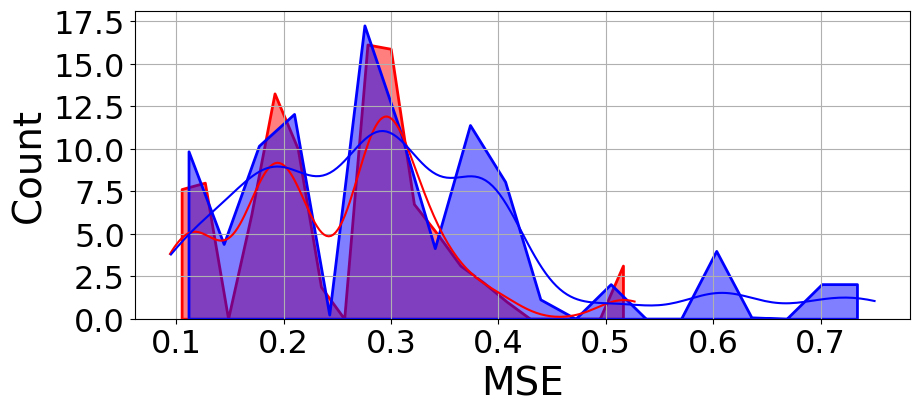

In [97]:
fig,ax = plt.subplots(1, 1, figsize=(10, 4))
sns.histplot(data=df_undefended, x='Malicious_Predicted_MSE', element="poly",
             cumulative=False, lw=2,stat='percent', log_scale=(False,False),
             color='red',kde=True,cbar=True,
             bins=20)
sns.histplot(data=df_distilled, x='Malicious_Predicted_MSE', element="poly",
             cumulative=False, lw=2,stat='percent', log_scale=(False,False),
             color='blue',kde=True,cbar=True,
             bins=20)
plt.xlabel(r'MSE', fontsize=28)
plt.ylabel(r'Count', fontsize=28)
plt.setp(ax.get_xticklabels(), fontsize=23)
plt.setp(ax.get_yticklabels(), fontsize=23)
plt.grid()
plt.show()

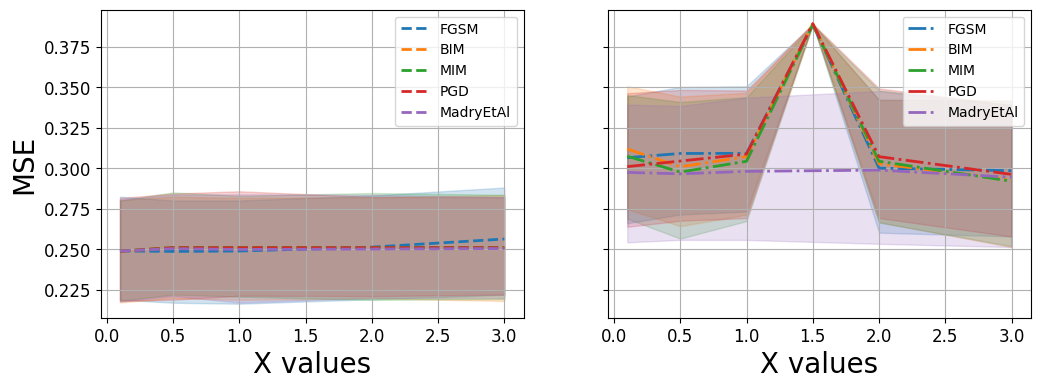

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for attack in attacks:
    df_tmp = df_undefended.query("Attack=='" + attack + "'" )
    sns.lineplot(data=df_tmp, x='eps', ax=ax[0], y='Malicious_Predicted_MSE', ls='--', lw=2, label=attack)

    df_tmp = df_distilled.query("Attack=='" + attack + "'" )
    sns.lineplot(data=df_tmp, x='eps', ax=ax[1], y='Malicious_Predicted_MSE', ls='-.', lw=2, label=attack)

for i in range(2):
    ax[i].set_ylabel('MSE', fontsize=20)
    ax[i].set_xlabel('X values', fontsize=20)  # Complete the string literal here
    ax[i].legend()
    ax[i].set(yscale="linear")
    ax[i].grid()
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)

plt.show()
